# Data Understanding

This notebook explores the structure and characteristics of the datasets provided for the assignment.

## Datasets to Explore:
1. `bundle_data.json.gz` - Bundle information
2. `australian_user_reviews.json.gz` - Australian user reviews
3. `australian_users_items.json.gz` - Australian user items
4. `steam_games.json.gz` - Steam games information
5. `steam_reviews.json.gz` - Steam reviews


In [1]:
import json
import gzip
import ast
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 100)

print("Libraries imported successfully!")


Libraries imported successfully!


## Helper Functions


In [2]:
def load_json_gz(filepath):
    """Load a gzipped JSON file - handles JSONL format with Python dict syntax (single quotes)"""
    data = []
    try:
        with gzip.open(filepath, 'rt', encoding='utf-8') as f:
            for line in f:
                line = line.strip()
                if line:
                    try:
                        # First try JSON (double quotes)
                        data.append(json.loads(line))
                    except json.JSONDecodeError:
                        try:
                            # If that fails, try Python literal eval (handles single quotes)
                            data.append(ast.literal_eval(line))
                        except (ValueError, SyntaxError) as e:
                            # Skip malformed lines
                            continue
    except Exception as e:
        print(f"Error loading {filepath}: {e}")
        import traceback
        traceback.print_exc()
        return []
    
    return data

def explore_data_structure(data, name, max_samples=5):
    """Explore the structure of a dataset"""
    print(f"\n{'='*80}")
    print(f"Dataset: {name}")
    print(f"{'='*80}")
    print(f"Total records: {len(data)}")
    
    if len(data) > 0:
        print(f"\nFirst record structure:")
        first_record = data[0]
        print(f"Type: {type(first_record)}")
        if isinstance(first_record, dict):
            print(f"Keys: {list(first_record.keys())}")
            print(f"\nFirst record sample:")
            for key, value in list(first_record.items())[:10]:
                print(f"  {key}: {type(value).__name__} - {str(value)[:100]}")
        elif isinstance(first_record, list):
            print(f"List length: {len(first_record)}")
            if len(first_record) > 0:
                print(f"First element type: {type(first_record[0])}")
        else:
            print(f"Value: {str(first_record)[:200]}")
        
        # Show a few sample records
        print(f"\nSample records (showing {min(max_samples, len(data))}):")
        for i, record in enumerate(data[:max_samples]):
            print(f"\n--- Record {i+1} ---")
            if isinstance(record, dict):
                for key, value in list(record.items())[:15]:
                    print(f"  {key}: {str(value)[:150]}")
            else:
                print(f"  {str(record)[:200]}")

def analyze_dataframe(df, name):
    """Analyze a pandas DataFrame"""
    print(f"\n{'='*80}")
    print(f"DataFrame: {name}")
    print(f"{'='*80}")
    print(f"Shape: {df.shape} (rows, columns)")
    print(f"\nColumn names and types:")
    print(df.dtypes)
    print(f"\nMissing values:")
    missing = df.isnull().sum()
    if missing.sum() > 0:
        print(missing[missing > 0])
    else:
        print("No missing values!")
    print(f"\nFirst few rows:")
    print(df.head())
    print(f"\nBasic statistics:")
    print(df.describe(include='all'))
    
print("Helper functions defined!")


Helper functions defined!


## Test File Loading


In [3]:
# Test loading one file to verify the function works
import os

test_file = 'data/bundle_data.json.gz'
if os.path.exists(test_file):
    print(f"File exists: {test_file}")
    print(f"File size: {os.path.getsize(test_file)} bytes")
    
    # Try loading
    test_data = load_json_gz(test_file)
    print(f"Loaded {len(test_data)} records")
    
    if len(test_data) > 0:
        print(f"First record type: {type(test_data[0])}")
        if isinstance(test_data[0], dict):
            print(f"First record keys: {list(test_data[0].keys())[:10]}")
else:
    print(f"File not found: {test_file}")
    print(f"Current directory: {os.getcwd()}")
    print(f"Files in data directory: {os.listdir('data') if os.path.exists('data') else 'data directory not found'}")


File exists: data/bundle_data.json.gz
File size: 92498 bytes
Loaded 615 records
First record type: <class 'dict'>
First record keys: ['bundle_final_price', 'bundle_url', 'bundle_price', 'bundle_name', 'bundle_id', 'items', 'bundle_discount']


## 1. Bundle Data


In [4]:
bundle_data = load_json_gz('data/bundle_data.json.gz')
explore_data_structure(bundle_data, 'Bundle Data', max_samples=3)



Dataset: Bundle Data
Total records: 615

First record structure:
Type: <class 'dict'>
Keys: ['bundle_final_price', 'bundle_url', 'bundle_price', 'bundle_name', 'bundle_id', 'items', 'bundle_discount']

First record sample:
  bundle_final_price: str - $66.46
  bundle_url: str - http://store.steampowered.com/bundle/450/?utm_source=SteamDB&utm_medium=SteamDB&utm_campaign=SteamDB
  bundle_price: str - $73.86
  bundle_name: str - Dharker Studio 2015 Complete
  bundle_id: str - 450
  items: list - [{'genre': 'Adventure, Indie, RPG', 'item_id': '326950', 'discounted_price': '$8.99', 'item_url': 'h
  bundle_discount: str - 10%

Sample records (showing 3):

--- Record 1 ---
  bundle_final_price: $66.46
  bundle_url: http://store.steampowered.com/bundle/450/?utm_source=SteamDB&utm_medium=SteamDB&utm_campaign=SteamDB%20Bundles%20Page
  bundle_price: $73.86
  bundle_name: Dharker Studio 2015 Complete
  bundle_id: 450
  items: [{'genre': 'Adventure, Indie, RPG', 'item_id': '326950', 'discounted_pr

In [5]:
# Convert to DataFrame if possible
if bundle_data and isinstance(bundle_data[0], dict):
    try:
        df_bundle = pd.DataFrame(bundle_data)
        analyze_dataframe(df_bundle, 'Bundle Data')
    except Exception as e:
        print(f"Could not convert to DataFrame: {e}")
        print("\nAnalyzing key patterns manually...")
        if 'bundle_id' in bundle_data[0]:
            bundle_ids = [item.get('bundle_id') for item in bundle_data]
            print(f"Unique bundle IDs: {len(set(bundle_ids))}")
        if 'items' in bundle_data[0]:
            item_counts = [len(item.get('items', [])) if isinstance(item.get('items'), list) else 0 for item in bundle_data]
            print(f"Average items per bundle: {np.mean(item_counts):.2f}")
            print(f"Min items: {min(item_counts)}, Max items: {max(item_counts)}")



DataFrame: Bundle Data
Shape: (615, 7) (rows, columns)

Column names and types:
bundle_final_price    object
bundle_url            object
bundle_price          object
bundle_name           object
bundle_id             object
items                 object
bundle_discount       object
dtype: object

Missing values:
No missing values!

First few rows:
  bundle_final_price  \
0             $66.46   
1             $20.15   
2             $20.15   
3             $15.17   
4             $20.15   

                                                                                            bundle_url  \
0  http://store.steampowered.com/bundle/450/?utm_source=SteamDB&utm_medium=SteamDB&utm_campaign=Ste...   
1  http://store.steampowered.com/bundle/1473/?utm_source=SteamDB&utm_medium=SteamDB&utm_campaign=St...   
2  http://store.steampowered.com/bundle/1474/?utm_source=SteamDB&utm_medium=SteamDB&utm_campaign=St...   
3  http://store.steampowered.com/bundle/1437/?utm_source=SteamDB&utm_medium=Stea

count    615.000000
mean       5.731707
std        8.013500
min        2.000000
25%        2.000000
50%        3.000000
75%        5.000000
max       89.000000
Name: n_items, dtype: float64


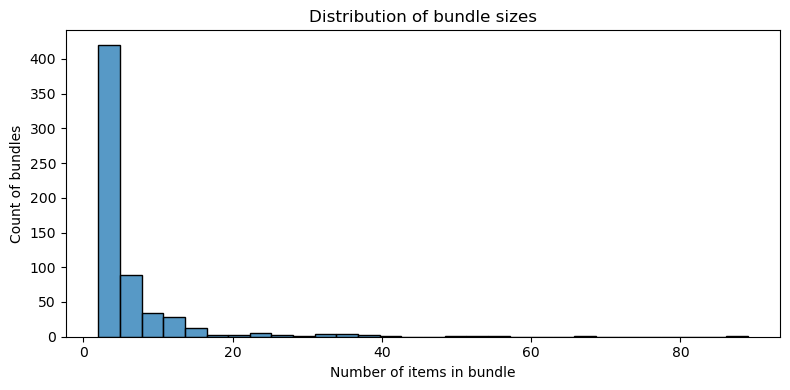

In [6]:
if 'df_bundle' in globals():
    # Number of items per bundle
    if 'items' in df_bundle.columns:
        df_bundle['n_items'] = df_bundle['items'].apply(
            lambda x: len(x) if isinstance(x, list) else 0
        )
        
        print(df_bundle['n_items'].describe())

        plt.figure(figsize=(8, 4))
        sns.histplot(df_bundle['n_items'], bins=30, kde=False)
        plt.xlabel("Number of items in bundle")
        plt.ylabel("Count of bundles")
        plt.title("Distribution of bundle sizes")
        plt.tight_layout()
        plt.show()


## 2. Australian User Reviews


In [7]:
australian_reviews = load_json_gz('data/australian_user_reviews.json.gz')
explore_data_structure(australian_reviews, 'Australian User Reviews', max_samples=2)



Dataset: Australian User Reviews
Total records: 25799

First record structure:
Type: <class 'dict'>
Keys: ['user_id', 'user_url', 'reviews']

First record sample:
  user_id: str - 76561197970982479
  user_url: str - http://steamcommunity.com/profiles/76561197970982479
  reviews: list - [{'funny': '', 'posted': 'Posted November 5, 2011.', 'last_edited': '', 'item_id': '1250', 'helpful'

Sample records (showing 2):

--- Record 1 ---
  user_id: 76561197970982479
  user_url: http://steamcommunity.com/profiles/76561197970982479
  reviews: [{'funny': '', 'posted': 'Posted November 5, 2011.', 'last_edited': '', 'item_id': '1250', 'helpful': 'No ratings yet', 'recommend': True, 'review': '

--- Record 2 ---
  user_id: js41637
  user_url: http://steamcommunity.com/id/js41637
  reviews: [{'funny': '', 'posted': 'Posted June 24, 2014.', 'last_edited': '', 'item_id': '251610', 'helpful': '15 of 20 people (75%) found this review helpful'


In [8]:
# Analyze Australian reviews structure
if australian_reviews:
    print("\nDetailed Analysis:")
    first_review = australian_reviews[0]
    
    if isinstance(first_review, dict):
        # Check if it's user-centric (reviews grouped by user)
        if 'user_id' in first_review or 'user' in first_review:
            print("Structure appears to be user-centric")
            user_ids = []
            total_reviews = 0
            for user_data in australian_reviews[:100]:  # Sample first 100
                if isinstance(user_data, dict):
                    user_id = user_data.get('user_id') or user_data.get('user')
                    user_ids.append(user_id)
                    reviews = user_data.get('reviews', [])
                    if isinstance(reviews, list):
                        total_reviews += len(reviews)
            
            print(f"Sample: {len(user_ids)} users, {total_reviews} reviews")
            if len(user_ids) > 0:
                print(f"Average reviews per user: {total_reviews/len(user_ids):.2f}")
        
        # Try to flatten and create DataFrame
        try:
            # If reviews are nested, try to extract them
            all_reviews = []
            for user_data in australian_reviews:
                if isinstance(user_data, dict) and 'reviews' in user_data:
                    user_id = user_data.get('user_id') or user_data.get('user', 'unknown')
                    for review in user_data.get('reviews', []):
                        if isinstance(review, dict):
                            review_copy = review.copy()
                            review_copy['user_id'] = user_id
                            all_reviews.append(review_copy)
            
            if all_reviews:
                df_reviews = pd.DataFrame(all_reviews)
                print(f"\nFlattened reviews DataFrame shape: {df_reviews.shape}")
                analyze_dataframe(df_reviews, 'Australian Reviews (Flattened)')
        except Exception as e:
            print(f"Could not flatten reviews: {e}")



Detailed Analysis:
Structure appears to be user-centric
Sample: 100 users, 229 reviews
Average reviews per user: 2.29

Flattened reviews DataFrame shape: (59305, 8)

DataFrame: Australian Reviews (Flattened)
Shape: (59305, 8) (rows, columns)

Column names and types:
funny          object
posted         object
last_edited    object
item_id        object
helpful        object
recommend        bool
review         object
user_id        object
dtype: object

Missing values:
No missing values!

First few rows:
  funny                     posted last_edited item_id  \
0         Posted November 5, 2011.                1250   
1            Posted July 15, 2011.               22200   
2           Posted April 21, 2011.               43110   
3            Posted June 24, 2014.              251610   
4        Posted September 8, 2013.              227300   

                                           helpful  recommend  \
0                                   No ratings yet       True   
1         

user_id    25458
dtype: int64


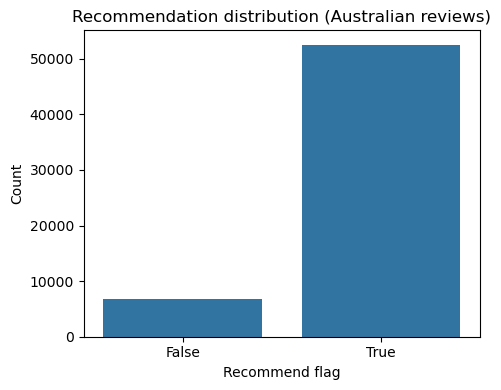

count    59305.00000
mean       215.66620
std        455.28899
min          0.00000
25%         30.00000
50%         78.00000
75%        207.00000
max       8000.00000
Name: text_len, dtype: float64


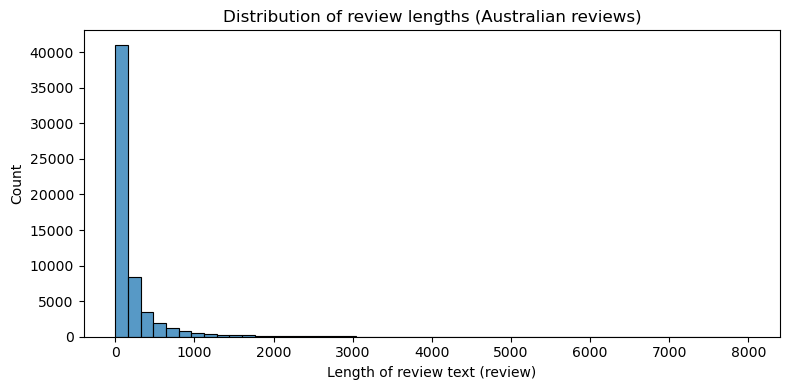

count    25458.000000
mean         2.329523
std          2.080373
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max         20.000000
Name: count, dtype: float64


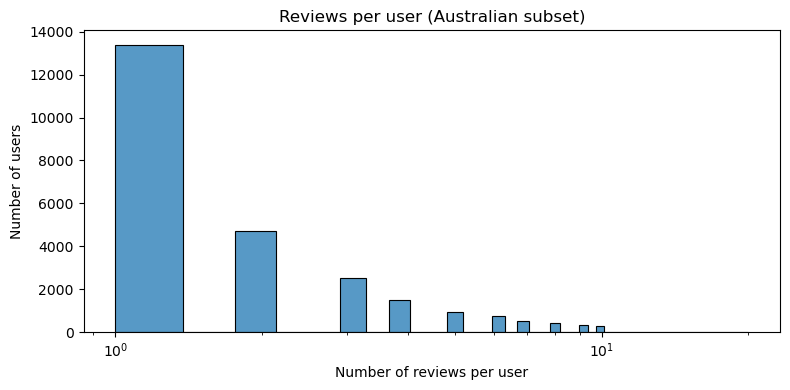

In [9]:
if 'df_reviews' in globals():
    print(df_reviews[['user_id']].nunique())

    # Recommendation distribution (if available)
    if 'recommend' in df_reviews.columns:
        plt.figure(figsize=(5, 4))
        sns.countplot(x='recommend', data=df_reviews)
        plt.title("Recommendation distribution (Australian reviews)")
        plt.xlabel("Recommend flag")
        plt.ylabel("Count")
        plt.tight_layout()
        plt.show()

    # Review text length distribution
    text_col_candidates = [c for c in df_reviews.columns if 'review' in c or 'text' in c]
    if text_col_candidates:
        text_col = text_col_candidates[0]
        df_reviews['text_len'] = df_reviews[text_col].astype(str).str.len()

        print(df_reviews['text_len'].describe())

        plt.figure(figsize=(8, 4))
        sns.histplot(df_reviews['text_len'], bins=50)
        plt.xlabel(f"Length of review text ({text_col})")
        plt.ylabel("Count")
        plt.title("Distribution of review lengths (Australian reviews)")
        plt.tight_layout()
        plt.show()

    # Reviews per user
    reviews_per_user = df_reviews['user_id'].value_counts()
    print(reviews_per_user.describe())

    plt.figure(figsize=(8, 4))
    sns.histplot(reviews_per_user, bins=50)
    plt.xlabel("Number of reviews per user")
    plt.ylabel("Number of users")
    plt.xscale('log')  # long-tail usually
    plt.title("Reviews per user (Australian subset)")
    plt.tight_layout()
    plt.show()


In [10]:
australian_items = load_json_gz('data/australian_users_items.json.gz')
explore_data_structure(australian_items, 'Australian Users Items', max_samples=2)



Dataset: Australian Users Items
Total records: 88310

First record structure:
Type: <class 'dict'>
Keys: ['user_id', 'items_count', 'steam_id', 'user_url', 'items']

First record sample:
  user_id: str - 76561197970982479
  items_count: int - 277
  steam_id: str - 76561197970982479
  user_url: str - http://steamcommunity.com/profiles/76561197970982479
  items: list - [{'item_id': '10', 'item_name': 'Counter-Strike', 'playtime_forever': 6, 'playtime_2weeks': 0}, {'it

Sample records (showing 2):

--- Record 1 ---
  user_id: 76561197970982479
  items_count: 277
  steam_id: 76561197970982479
  user_url: http://steamcommunity.com/profiles/76561197970982479
  items: [{'item_id': '10', 'item_name': 'Counter-Strike', 'playtime_forever': 6, 'playtime_2weeks': 0}, {'item_id': '20', 'item_name': 'Team Fortress Classic'

--- Record 2 ---
  user_id: js41637
  items_count: 888
  steam_id: 76561198035864385
  user_url: http://steamcommunity.com/id/js41637
  items: [{'item_id': '10', 'item_name': 'C

In [11]:
# Analyze Australian users items
if australian_items:
    print("\nDetailed Analysis:")
    first_item = australian_items[0]
    
    if isinstance(first_item, dict):
        # Check structure
        user_ids = []
        total_items = 0
        item_types = Counter()
        
        for user_data in australian_items[:100]:  # Sample first 100
            if isinstance(user_data, dict):
                user_id = user_data.get('user_id') or user_data.get('user')
                user_ids.append(user_id)
                
                # Check for items or item_id fields
                items = user_data.get('items', [])
                if isinstance(items, list):
                    total_items += len(items)
                    for item in items:
                        if isinstance(item, dict):
                            item_types.update(item.keys())
        
        print(f"Sample: {len(user_ids)} users, {total_items} items")
        if len(user_ids) > 0:
            print(f"Average items per user: {total_items/len(user_ids):.2f}")
        print(f"Common item fields: {item_types.most_common(10)}")
        
        # Try to create DataFrame
        try:
            all_items = []
            for user_data in australian_items:
                if isinstance(user_data, dict):
                    user_id = user_data.get('user_id') or user_data.get('user', 'unknown')
                    items = user_data.get('items', [])
                    if isinstance(items, list):
                        for item in items:
                            if isinstance(item, dict):
                                item_copy = item.copy()
                                item_copy['user_id'] = user_id
                                all_items.append(item_copy)
            
            if all_items:
                df_items = pd.DataFrame(all_items)
                print(f"\nFlattened items DataFrame shape: {df_items.shape}")
                analyze_dataframe(df_items, 'Australian Users Items (Flattened)')
        except Exception as e:
            print(f"Could not flatten items: {e}")



Detailed Analysis:
Sample: 100 users, 10150 items
Average items per user: 101.50
Common item fields: [('item_id', 10150), ('item_name', 10150), ('playtime_forever', 10150), ('playtime_2weeks', 10150)]

Flattened items DataFrame shape: (5153209, 5)

DataFrame: Australian Users Items (Flattened)
Shape: (5153209, 5) (rows, columns)

Column names and types:
item_id             object
item_name           object
playtime_forever     int64
playtime_2weeks      int64
user_id             object
dtype: object

Missing values:
No missing values!

First few rows:
  item_id                  item_name  playtime_forever  playtime_2weeks  \
0      10             Counter-Strike                 6                0   
1      20      Team Fortress Classic                 0                0   
2      30              Day of Defeat                 7                0   
3      40         Deathmatch Classic                 0                0   
4      50  Half-Life: Opposing Force                 0            

count    70912.000000
mean        72.670479
std        134.056122
min          1.000000
25%         14.000000
50%         40.000000
75%         88.000000
max       7762.000000
Name: count, dtype: float64


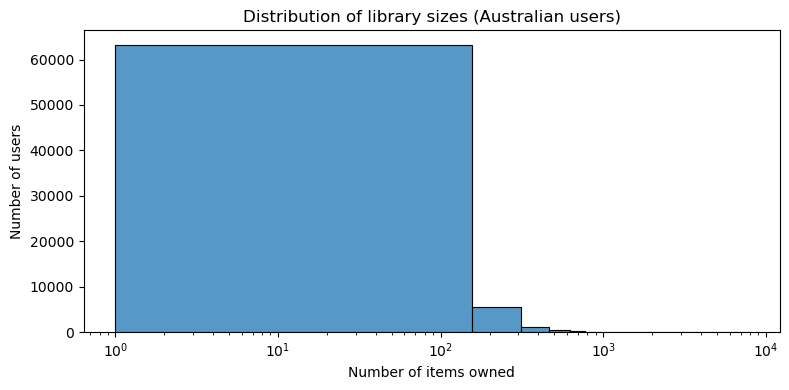

item_id
205790    49571
730       43776
4000      43301
304930    38682
223530    37044
550       37044
105600    29239
230410    25807
620       24465
240       24220
218620    23729
72850     22285
301520    21785
49520     21029
218230    20726
340       19826
227940    19721
400       18774
220       18307
236390    18172
Name: count, dtype: int64


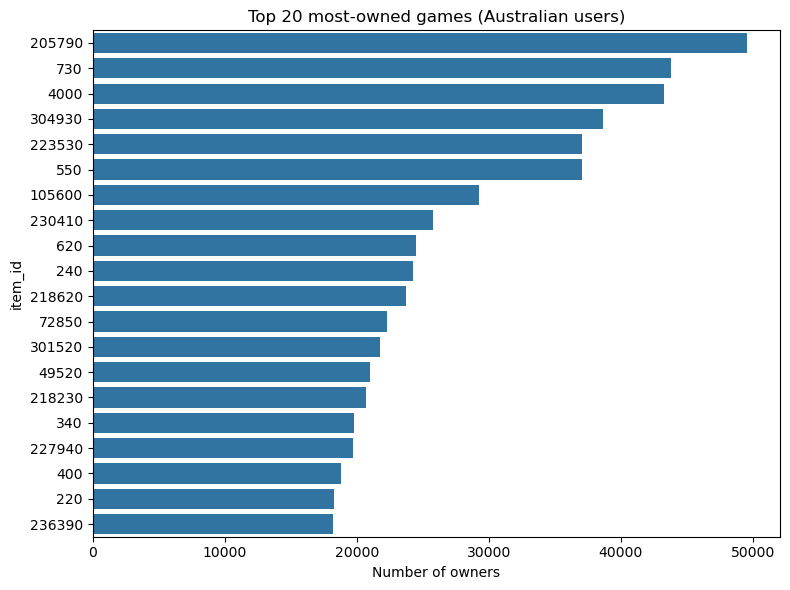

In [12]:
if 'df_items' in globals():
    # Items per user
    if 'user_id' in df_items.columns:
        items_per_user = df_items['user_id'].value_counts()
        print(items_per_user.describe())

        plt.figure(figsize=(8, 4))
        sns.histplot(items_per_user, bins=50)
        plt.xlabel("Number of items owned")
        plt.ylabel("Number of users")
        plt.xscale('log')
        plt.title("Distribution of library sizes (Australian users)")
        plt.tight_layout()
        plt.show()

    # Most common items
    item_key = None
    for c in ['item_id', 'app_id', 'game_id']:
        if c in df_items.columns:
            item_key = c
            break

    if item_key is not None:
        top_items = df_items[item_key].value_counts().head(20)
        print(top_items)

        plt.figure(figsize=(8, 6))
        sns.barplot(x=top_items.values, y=top_items.index)
        plt.xlabel("Number of owners")
        plt.ylabel(item_key)
        plt.title("Top 20 most-owned games (Australian users)")
        plt.tight_layout()
        plt.show()


In [13]:
steam_games = load_json_gz('data/steam_games.json.gz')
explore_data_structure(steam_games, 'Steam Games', max_samples=3)



Dataset: Steam Games
Total records: 32135

First record structure:
Type: <class 'dict'>
Keys: ['publisher', 'genres', 'app_name', 'title', 'url', 'release_date', 'tags', 'discount_price', 'reviews_url', 'specs', 'price', 'early_access', 'id', 'developer']

First record sample:
  publisher: str - Kotoshiro
  genres: list - ['Action', 'Casual', 'Indie', 'Simulation', 'Strategy']
  app_name: str - Lost Summoner Kitty
  title: str - Lost Summoner Kitty
  url: str - http://store.steampowered.com/app/761140/Lost_Summoner_Kitty/
  release_date: str - 2018-01-04
  tags: list - ['Strategy', 'Action', 'Indie', 'Casual', 'Simulation']
  discount_price: float - 4.49
  reviews_url: str - http://steamcommunity.com/app/761140/reviews/?browsefilter=mostrecent&p=1
  specs: list - ['Single-player']

Sample records (showing 3):

--- Record 1 ---
  publisher: Kotoshiro
  genres: ['Action', 'Casual', 'Indie', 'Simulation', 'Strategy']
  app_name: Lost Summoner Kitty
  title: Lost Summoner Kitty
  url: htt

In [14]:
# Convert to DataFrame
if steam_games and isinstance(steam_games[0], dict):
    try:
        df_games = pd.DataFrame(steam_games)
        analyze_dataframe(df_games, 'Steam Games')
        
        # Additional analysis for games
        if 'id' in df_games.columns:
            print(f"\nUnique game IDs: {df_games['id'].nunique()}")
        if 'app_name' in df_games.columns:
            print(f"Unique game names: {df_games['app_name'].nunique()}")
        if 'price' in df_games.columns:
            print(f"\nPrice statistics:")
            print(df_games['price'].describe())
    except Exception as e:
        print(f"Error analyzing games: {e}")



DataFrame: Steam Games
Shape: (32135, 16) (rows, columns)

Column names and types:
publisher          object
genres             object
app_name           object
title              object
url                object
release_date       object
tags               object
discount_price    float64
reviews_url        object
specs              object
price              object
early_access         bool
id                 object
developer          object
sentiment          object
metascore          object
dtype: object

Missing values:
publisher          8052
genres             3283
app_name              2
title              2050
release_date       2067
tags                163
discount_price    31910
reviews_url           2
specs               670
price              1377
id                    2
developer          3299
sentiment          7182
metascore         29458
dtype: int64

First few rows:
          publisher                                             genres  \
0         Kotoshiro      [Act

count    28848.000000
mean         9.453921
std         16.251641
min          0.490000
25%          2.990000
50%          4.990000
75%          9.990000
max        995.000000
Name: price, dtype: float64


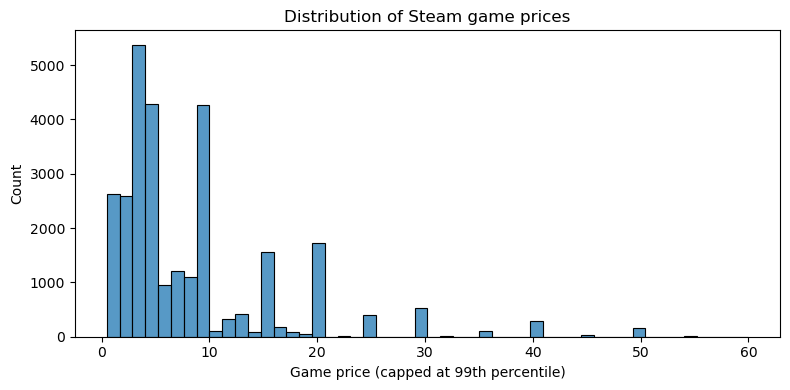

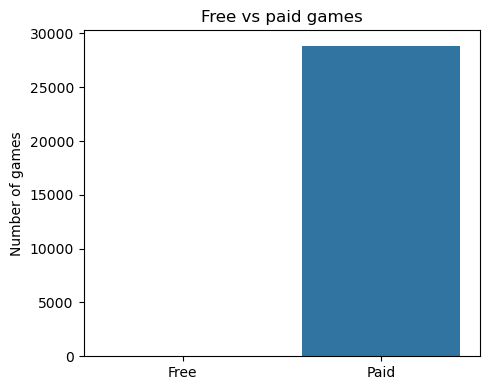

Indie                        15858
Action                       11321
Casual                        8282
Adventure                     8243
Strategy                      6957
Simulation                    6699
RPG                           5479
Free to Play                  2031
Early Access                  1462
Sports                        1257
Massively Multiplayer         1108
Racing                        1083
Design &amp; Illustration      460
Utilities                      340
Web Publishing                 268
Animation &amp; Modeling       183
Education                      125
Video Production               116
Software Training              105
Audio Production                93
dtype: int64


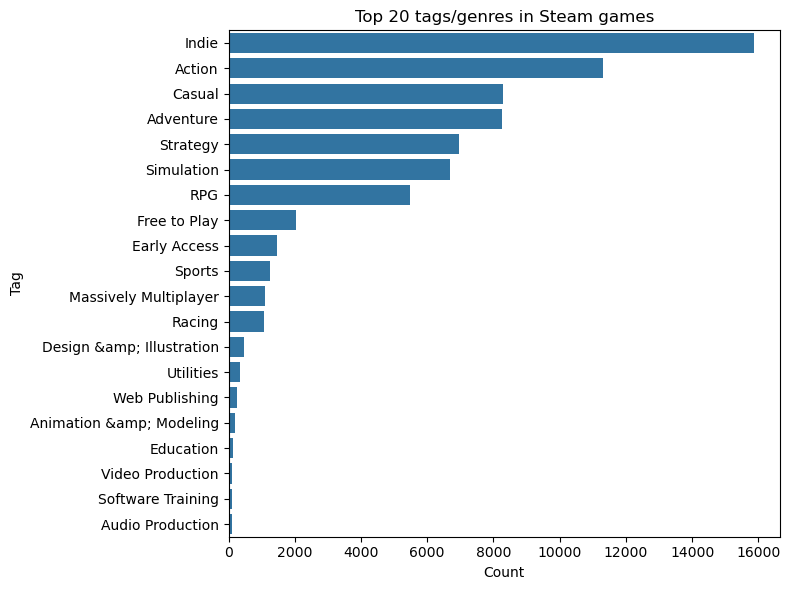

In [15]:
# --- Steam games exploration ---

if 'df_games' in globals():
    # Price distribution (ignoring free games and missing prices)
    if 'price' in df_games.columns:
        price_series = pd.to_numeric(df_games['price'], errors='coerce')
        price_series = price_series.dropna()

        print(price_series.describe())

        plt.figure(figsize=(8, 4))
        sns.histplot(price_series[price_series < price_series.quantile(0.99)], bins=50)
        plt.xlabel("Game price (capped at 99th percentile)")
        plt.ylabel("Count")
        plt.title("Distribution of Steam game prices")
        plt.tight_layout()
        plt.show()

        # Proportion free vs paid, if you can infer free
        is_free = price_series == 0
        plt.figure(figsize=(5, 4))
        sns.barplot(x=['Free', 'Paid'], y=[is_free.sum(), (~is_free).sum()])
        plt.ylabel("Number of games")
        plt.title("Free vs paid games")
        plt.tight_layout()
        plt.show()

    # Top tags / genres (if you have such a column)
    tag_cols = [c for c in df_games.columns if 'tag' in c or 'genre' in c]
    if tag_cols:
        tag_col = tag_cols[0]
        # assuming tag_col is list-like or semicolon-separated
        def split_tags(x):
            if isinstance(x, list):
                return x
            if isinstance(x, str):
                return [t.strip() for t in x.split(',') if t.strip()]
            return []

        all_tags = df_games[tag_col].dropna().apply(split_tags)
        tag_counter = Counter(t for tags in all_tags for t in tags)

        top_tags = pd.Series(tag_counter).sort_values(ascending=False).head(20)
        print(top_tags)

        plt.figure(figsize=(8, 6))
        sns.barplot(x=top_tags.values, y=top_tags.index)
        plt.xlabel("Count")
        plt.ylabel("Tag")
        plt.title("Top 20 tags/genres in Steam games")
        plt.tight_layout()
        plt.show()


## 5. Steam Reviews


In [16]:
steam_reviews = load_json_gz('data/steam_reviews.json.gz')
explore_data_structure(steam_reviews, 'Steam Reviews', max_samples=3)



Dataset: Steam Reviews
Total records: 7793069

First record structure:
Type: <class 'dict'>
Keys: ['username', 'hours', 'products', 'product_id', 'page_order', 'date', 'text', 'early_access', 'page']

First record sample:
  username: str - Chaos Syren
  hours: float - 0.1
  products: int - 41
  product_id: str - 725280
  page_order: int - 0
  date: str - 2017-12-17
  text: str - This would not be acceptable as an entertainment even back in the day when these graphics were all t
  early_access: bool - False
  page: int - 1

Sample records (showing 3):

--- Record 1 ---
  username: Chaos Syren
  hours: 0.1
  products: 41
  product_id: 725280
  page_order: 0
  date: 2017-12-17
  text: This would not be acceptable as an entertainment even back in the day when these graphics were all there was to be had. No effort has been made to bri
  early_access: False
  page: 1

--- Record 2 ---
  username: ₮ʜᴇ Wᴀʀᴛᴏɴ
  hours: 51.1
  products: 769
  product_id: 328100
  page_order: 0
  date: 2017-12-2

In [17]:
# Convert to DataFrame
if steam_reviews and isinstance(steam_reviews[0], dict):
    try:
        df_steam_reviews = pd.DataFrame(steam_reviews)
        analyze_dataframe(df_steam_reviews, 'Steam Reviews')
        
        # Additional analysis
        if 'user_id' in df_steam_reviews.columns:
            print(f"\nUnique users: {df_steam_reviews['user_id'].nunique()}")
            print(f"Reviews per user (avg): {len(df_steam_reviews) / df_steam_reviews['user_id'].nunique():.2f}")
        if 'item_id' in df_steam_reviews.columns or 'app_id' in df_steam_reviews.columns:
            item_col = 'item_id' if 'item_id' in df_steam_reviews.columns else 'app_id'
            print(f"Unique items: {df_steam_reviews[item_col].nunique()}")
        if 'recommend' in df_steam_reviews.columns:
            print(f"\nRecommendation distribution:")
            print(df_steam_reviews['recommend'].value_counts())
        if 'sentiment' in df_steam_reviews.columns:
            print(f"\nSentiment distribution:")
            print(df_steam_reviews['sentiment'].value_counts())
    except Exception as e:
        print(f"Error analyzing reviews: {e}")



DataFrame: Steam Reviews
Shape: (7793069, 12) (rows, columns)

Column names and types:
username         object
hours           float64
products        float64
product_id       object
page_order        int64
date             object
text             object
early_access       bool
page              int64
found_funny     float64
compensation     object
user_id          object
dtype: object

Missing values:
hours             26537
products          14961
found_funny     6592313
compensation    7647446
user_id         4616846
dtype: int64

First few rows:
         username  hours  products product_id  page_order        date  \
0     Chaos Syren    0.1      41.0     725280           0  2017-12-17   
1      ₮ʜᴇ Wᴀʀᴛᴏɴ   51.1     769.0     328100           0  2017-12-27   
2         hello?<   14.6       2.0     328100           1  2017-10-16   
3     Cyderine916    5.0      64.0      35140           0  2018-01-04   
4  DarklyThinking   16.6     577.0      35140           1  2018-01-04   

    

## Summary and Key Insights


In [20]:
# Create a summary of all datasets
print("="*80)
print("DATASET SUMMARY")
print("="*80)

datasets = [
    ("Bundle Data", bundle_data),
    ("Australian User Reviews", australian_reviews),
    ("Australian Users Items", australian_items),
    ("Steam Games", steam_games),
    ("Steam Reviews", steam_reviews)
]

summary_data = []
for name, data in datasets:
    if data:
        summary_data.append({
            'Dataset': name,
            'Total Records': len(data),
            'First Record Type': type(data[0]).__name__ if len(data) > 0 else 'N/A',
            'Has Nested Structure': isinstance(data[0], dict) and any(isinstance(v, (list, dict)) for v in (data[0].values() if isinstance(data[0], dict) else []))
        })
    else:
        summary_data.append({
            'Dataset': name,
            'Total Records': 0,
            'First Record Type': 'N/A',
            'Has Nested Structure': False
        })

df_summary = pd.DataFrame(summary_data)
print("\n", df_summary.to_string(index=False))



DATASET SUMMARY

                 Dataset  Total Records First Record Type  Has Nested Structure
            Bundle Data            615              dict                  True
Australian User Reviews          25799              dict                  True
 Australian Users Items          88310              dict                  True
            Steam Games          32135              dict                  True
          Steam Reviews        7793069              dict                 False
